In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch

from scipy.interpolate import interp2d
from scipy.stats import beta, multivariate_normal, nct, t

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Inputs**:
- A small number of calibration data for each class $k$
- A prior distribution on the Beta distribution parameters. Eventually, we will want to estimate these using maximum likelihood (a la empirical Bayes), but until I figure out how to do that, we will use the KDE distribution fit to the "ground truth" parameters (estimated using all of ImageNet train)

# 1. Setup

## 1a. Prepare inputs

In [11]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [12]:
# Select subset of data
np.random.seed(0)

n = 20 # Number of calibration points per class k
num_classes = 1000

softmax_scores_subset = np.zeros((num_classes * n, num_classes))
labels_subset = np.zeros((num_classes * n, ), dtype=np.int8)

for k in range(num_classes):
    
    # Randomly select n instances of class k
    idx = np.argwhere(labels==k).flatten()
    selected_idx = np.random.choice(idx, replace=False, size=(n,))
    
    softmax_scores_subset[n*k:n*(k+1), :] = softmax_scores[selected_idx, :]
    labels_subset[n*k:(n+1)*k] = k

In [150]:
# Only select data for which k is true class
scores_subset = np.array([softmax_scores_subset[row,labels_subset[row]] for row in range(len(labels_subset))])

In [5]:
# Load KDE estimate of prior
with open('.cache/kde.pkl', 'rb') as f:
    kde = pickle.load(f)

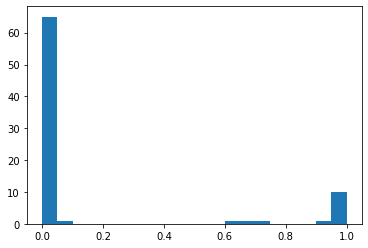

In [163]:
# Sanity check: Plot score distribution for a single class
k = 34
vals = scores_subset[labels_subset==k]
plt.hist(vals, bins=20)
plt.show()

## 1b. Hyperparameters and helper functions

In [164]:
# ===== Hyperparameters =====

num_classes = 1000

# Grid
xmin, xmax = 0, 4 # Grid bounds
ymin, ymax = 0, 4 # Grid bounds
nbins = 100 # Use 100 x 100 grid for now
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # Use 100 x 100 grid for now
positions = np.vstack([X.ravel(), Y.ravel()])

# # Threshold for truncating probability distribution
# threshold = .001 # this is over a small area 

# Number of rejection sampling samplies
num_samples = 1000

# Grid for discretizing Beta mixture
mixture_grid = np.linspace(1e-5,1-(1e-5),2000) # Exclude 0 and 1 since Beta density blows up at those points

# Specify quantile
alpha = 0.1

In [165]:
D = kde(positions) # Evaluate D on grid

In [117]:
def compute_classk_prod_f(k, a, b, scores_subset,logscale=False):
    '''
    Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    
    Inputs:
        k: class
        a, b: parameters of Beta(a,b)
    '''
    f_ski = beta.pdf(scores_subset[k*n:(k+1)*n], a, b)
    
    if logscale:
        log_prod = np.sum(np.log(f_ski))
        return log_prod
    else:     
        prod = np.prod(f_ski)
        return prod

def compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, scores_subset):
    '''
    Applies compute_classk_prod_f to all grid points in positions. Replaces nan entries
    with 0 and normalizes the distribution 
    
    Outputs:
        prob: vector of probabilities
        density: prob reshaped into a matrix
    '''

    prod_f = np.array([compute_classk_prod_f(k, positions[0,i], positions[1,i], scores_subset) 
                       for i in range(len(positions[0]))])
    prob = prod_f * D

    # Replace nan entries with 0
    prob[np.isnan(prob)] = 0

    # We can normalize this discretized distribution
    grid_area = ((xmax - xmin) / nbins) * ((ymax - ymin) / nbins)
    prob = prob / (np.sum(prob * grid_area))
    
    # Reshape probs from vector into square matrix
    density = np.reshape(prob, X.shape) 

    return prob, density


def get_quantile(density, grid, alpha):
    assert(np.sum(np.isnan(density) + np.isinf(density)) == 0)
    
#     density /= np.sum(density) # ensure that density is normalized to sum to 1
    grid_width = grid[1] - grid[0]
    sums = np.cumsum(density) * grid_width
    min_idx = np.argwhere(sums >= 1 - alpha)[0,0]
    
    return grid[min_idx]

In [ ]:
%%time

quantiles = np.zeros((num_classes,))

mixture_grid = np.linspace(1e-5,1-(1e-5),1000) # Exclude 0 and 1 since Beta density blows up at those points

for k in range(num_classes):
    print(f"Class {k}")

    # Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, scores_subset)
    weights = prob / np.sum(prob)
    
    mixture_density = np.zeros(mixture_grid.shape)
    for i in range(len(prob)):
#         print(positions[0,i], positions[1,i])
        vals = weights[i] * beta.pdf(mixture_grid, positions[0,i], positions[1,i])
        vals[np.isnan(vals)] = 0 # Replace nan entries with 0
        mixture_density += vals
#         print(mixture_density)

    # Compute quantile
    quantile = get_quantile(mixture_density, mixture_grid, alpha)
    print(f"Quantile: {quantile:.4f}")
    quantiles[k] = quantile
    
#     break

Class 0
Quantile: 1.0000
Class 1
Quantile: 0.0000
Class 2
Quantile: 0.0000
Class 3
Quantile: 0.0000
Class 4
Quantile: 0.0000
Class 5
Quantile: 0.0000
Class 6


In [133]:
t = beta.pdf(mixture_grid, positions[0,i], positions[1,i])
t.sum()

9999.199983999679

In [142]:
grid_width = mixture_grid[1] - mixture_grid[0]
t.sum() * grid_width

1.0

In [135]:
d = mixture_density / mixture_density.sum()
get_quantile(d, mixture_grid, alpha)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [139]:
sums = np.cumsum(d)
sums

array([0.00120979, 0.00152592, 0.00175021, ..., 0.79061348, 0.81768055,
       1.        ])

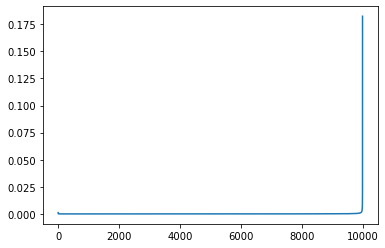

In [140]:
plt.plot(d)

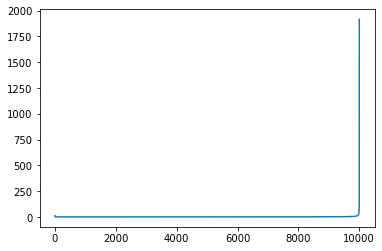

In [130]:
plt.plot(mixture_density)

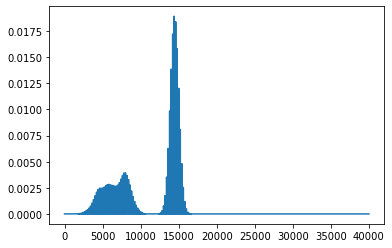

In [26]:
plt.plot(weights)

In [166]:
# Test seaborn plotting
# x = np.linspace(0,1,20)

# import pandas as pd
# import seaborn as sns
# df = pd.DataFrame({'vals': x})
# sns.relplot(x='vals', y='vals', size="vals", sizes=(20, 200), alpha=0.5, data=df)

## 2. Estimate quantiles

Let $f(x; \alpha, \beta) := \frac{1}{B(\alpha,\beta)}x^{\alpha-1}(1-x)^{\beta-1}$ denote the probability density function of $Beta(\alpha, \beta)$. Let $D(\alpha, \beta)$ denote the prior distribution of the Beta distribution parameters $\alpha$ and $\beta$. 

The distribution of an arbitrary score $s_{k,new}$ for class $k$ is a mixture of Betas:
$$p(s_{k,new}) = \int_0^{\infty} \int_0^{\infty} f(s_{k,new}; \alpha_k, \beta_k) p(\alpha_k, \beta_k | s_k, D) d\alpha_k d\beta_k$$


First, let's figure out how to sample from $p(\alpha_k, \beta_k | s_k, D)$

**Step 1**: Plot $p(\alpha_k, \beta_k | s_k, D)\propto \prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k) D(\alpha, \beta)$

# Debugging

In [54]:
# # Visualize D(alpha, beta)
# max_D = np.max(D)
# for i in range(positions.shape[1]):
#     weight = D[i] / max_D
#     plt.scatter(positions[0,i], positions[1,i], alpha=weight,  color='blue')

# plt.xlabel('$\\alpha$')
# plt.ylabel('$\\beta$')
# plt.title('$D(\\alpha, \\beta)$')
# plt.show()

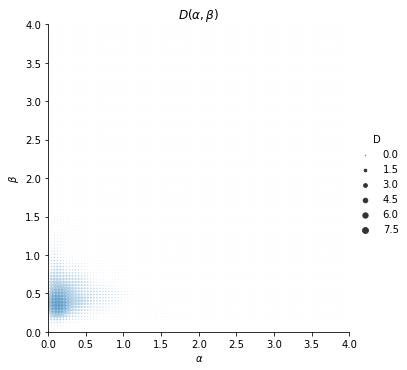

In [168]:
# Visualize D(alpha, beta)
df = pd.DataFrame({'alpha': positions[0,:], 'beta': positions[1,:], 'D': D})
sns.relplot(x='alpha', y='beta', size='D', sizes=(0.1, 40), alpha=0.3, data=df)

plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('$D(\\alpha, \\beta)$')
plt.show()

In [172]:
# Choose class
k = 3

prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, scores_subset)

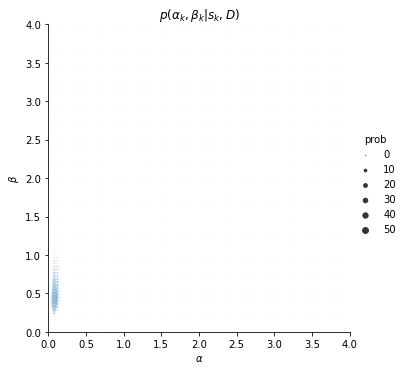

In [173]:
# Visualize p(\alpha_k, \beta_k | s_k, D)
df = pd.DataFrame({'alpha': positions[0,:], 'beta': positions[1,:], 'prob': prob})
sns.relplot(x='alpha', y='beta', size='prob', sizes=(0.1, 40), alpha=0.3, data=df)

plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('$p(\\alpha_k, \\beta_k | s_k, D)$')
plt.show()

Text(0.5, 1.0, 'Density of Beta(0.1, 0.5)')

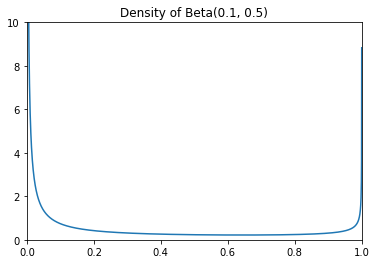

In [174]:
# Visualize Beta densities
a = 0.1 # alpha
b = 0.5 # beta

grid = np.linspace(1e-4,1-1e-4,2000)
beta_density = beta.pdf(grid, a, b)
plt.plot(grid, beta_density)
# plt.ylim(bottom=0)
plt.ylim(0,10)
plt.xlim(0,1)
plt.title(f"Density of Beta({a}, {b})")

In [175]:
alpha = 0.1
get_quantile(beta_density, grid, alpha)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [178]:
grid_width = grid[1] - grid[0]
density = beta_density
sums = np.cumsum(density) * grid_width
sums  

array([0.17585601, 0.21091763, 0.23124188, ..., 0.769693  , 0.77149702,
       0.7759145 ])

In [176]:
# Inverse cdf
beta.ppf(1-alpha, a, b)

0.7327778086894582

In [123]:
alpha = 0.1
density = beta_density
grid_width = grid[1] - grid[0]
sums = np.cumsum(density) * grid_width
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [122]:
alpha = 0.1
density = beta_density
density /= np.sum(density) # ensure that density is normalized to sum to 1
sums = np.cumsum(density)
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]

# return grid[min_idx]
sums
grid[min_idx]

0.9999

## Sampling approach (6/1/22)
Sample $\alpha_k, \beta_k \sim p(\alpha_k, \beta_k | s_k, D)$. Then sample $s_{k,i} \sim \text{Beta}(\alpha_k, \beta_k)$. Repeat $n$ times

In [ ]:
%%time

quantiles = np.zeros((num_classes,))

num_samples = 100000

# mixture_grid = np.linspace(1e-5,1-(1e-5),1000) # Exclude 0 and 1 since Beta density blows up at those points

for k in range(num_classes):
    print(f"Class {k}")

    # Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, scores_subset)
    normalized_prob = prob / np.sum(prob)
    
    samples = np.zeros((num_samples,))
    
    for i in range(num_samples):
        
        # 1. Sample alpha_k, beta_k
        idx = np.random.choice(np.arange(len(normalized_prob)), p=normalized_prob)
        alpha_k = positions[0,idx]
        beta_k = positions[1, idx]
#         print('alpha_k, beta_k:', alpha_k, beta_k)
        
        # 2. Sample score
        samples[i] = np.random.beta(alpha_k, beta_k)
    
#     mixture_density = np.zeros(mixture_grid.shape)
#     for i in range(len(prob)):
# #         print(positions[0,i], positions[1,i])
#         vals = weights[i] * beta.pdf(mixture_grid, positions[0,i], positions[1,i])
#         vals[np.isnan(vals)] = 0 # Replace nan entries with 0
#         mixture_density += vals
# #         print(mixture_density)

    # Compute quantile
    samples = np.sort(samples)
    quantile = np.quantile(samples, np.ceil((1-alpha)*(n+1))/n)
    
    print(f"Quantile: {quantile:.4f}")
    quantiles[k] = quantile
    
#     break

Class 0
Quantile: 1.0000
Class 1
Quantile: 0.9102
Class 2
Quantile: 0.9572
Class 3
Quantile: 0.9390
Class 4
Quantile: 0.9937
Class 5
Quantile: 0.9152
Class 6
Quantile: 0.9932
Class 7
Quantile: 0.9961
Class 8
Quantile: 0.9942
Class 9
Quantile: 0.9999
Class 10
Quantile: 0.9999
Class 11
Quantile: 0.9999
Class 12
Quantile: 0.9998
Class 13
Quantile: 1.0000
Class 14
Quantile: 1.0000
Class 15
Quantile: 1.0000
Class 16
Quantile: 0.9999
Class 17
Quantile: 1.0000
Class 18
Quantile: 1.0000
Class 19
Quantile: 1.0000
Class 20
Quantile: 1.0000
Class 21
Quantile: 0.9990
Class 22
Quantile: 1.0000
Class 23
Quantile: 0.9995
Class 24
Quantile: 1.0000
Class 25
Quantile: 1.0000
Class 26
Quantile: 0.9993
Class 27
Quantile: 0.9996
Class 28
Quantile: 1.0000
Class 29
Quantile: 1.0000
Class 30
Quantile: 1.0000
Class 31
Quantile: 0.9993
Class 32
Quantile: 0.9993
Class 33
Quantile: 0.9995
Class 34
Quantile: 1.0000
Class 35
Quantile: 0.9988
Class 36
Quantile: 0.9955
Class 37
Quantile: 0.9997
Class 38
Quantile: 1.0

Quantile: 0.7608
Class 312
Quantile: 0.7626
Class 313
Quantile: 0.7577
Class 314
Quantile: 0.7550
Class 315
Quantile: 0.7626
Class 316
Quantile: 0.7562
Class 317
Quantile: 0.7447
Class 318
Quantile: 0.7622
Class 319
Quantile: 0.7629
Class 320
Quantile: 0.7571
Class 321
Quantile: 0.7351
Class 322
Quantile: 0.7576
Class 323
Quantile: 0.7465
Class 324
Quantile: 0.7589
Class 325
Quantile: 0.7432
Class 326
Quantile: 0.7664
Class 327
Quantile: 0.7387
Class 328
Quantile: 0.7306
Class 329
Quantile: 0.7305
Class 330
Quantile: 0.7516
Class 331
Quantile: 0.7573
Class 332
Quantile: 0.7451
Class 333
Quantile: 0.7626
Class 334
Quantile: 0.7589
Class 335
Quantile: 0.7507
Class 336
Quantile: 0.7642
Class 337
Quantile: 0.7620
Class 338
Quantile: 0.7637
Class 339
Quantile: 0.7494
Class 340
Quantile: 0.7445
Class 341
Quantile: 0.7590
Class 342
Quantile: 0.7626
Class 343
Quantile: 0.7477
Class 344
Quantile: 0.7537
Class 345
Quantile: 0.7545
Class 346
Quantile: 0.7525
Class 347
Quantile: 0.7486
Class 348
Q

Quantile: 0.7584
Class 616
Quantile: 0.7434
Class 617
Quantile: 0.7570
Class 618
Quantile: 0.7631
Class 619
Quantile: 0.7627
Class 620
Quantile: 0.7720
Class 621
Quantile: 0.7633
Class 622
Quantile: 0.7404
Class 623
Quantile: 0.7729
Class 624
Quantile: 0.7494
Class 625
Quantile: 0.7354
Class 626
Quantile: 0.7682
Class 627
Quantile: 0.7456
Class 628
Quantile: 0.7541
Class 629
Quantile: 0.7430
Class 630
Quantile: 0.7561
Class 631
Quantile: 0.7478
Class 632
Quantile: 0.7568
Class 633
Quantile: 0.7573
Class 634
Quantile: 0.7656
Class 635
Quantile: 0.7513
Class 636
Quantile: 0.7461
Class 637
Quantile: 0.7623
Class 638
Quantile: 0.7533
Class 639
Quantile: 0.7644
Class 640
Quantile: 0.7212
Class 641
Quantile: 0.7562
Class 642
Quantile: 0.7005
Class 643
Quantile: 0.7655
Class 644
Quantile: 0.7590
Class 645
Quantile: 0.7532
Class 646
Quantile: 0.7319
Class 647
Quantile: 0.7612
Class 648
Quantile: 0.7602
Class 649
Quantile: 0.7322
Class 650
Quantile: 0.7752
Class 651
Quantile: 0.7645
Class 652
Q

In [ ]:
np.save('quantiles_060122.npy', quantiles)

## Debugging

Compare discretized quantile estimate to ppf quantile estimate for a Beta distribution

Discretized quantile estimate: 1e-10
ppf quantile estimate: 0.7327778086894582


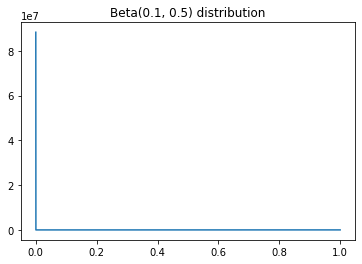

In [265]:
a = 0.1
b = 0.5

# a = 2
# b = 2

alpha = 0.1

## 1.  Discretized
eps = 1e-10 # To avoid evaluating Beta at 0 or 1, where density blows up to infinity for some alpha, beta combos

# Option A: Basic grid
grid = np.linspace(eps, 1-eps, 10000000)

# Option B: Grid with higher density at tails
# grid1 = np.linspace(eps, 0.1, 10000)
# grid2 = np.linspace(0.1, 0.9, 2000)
# grid3 = 1 - grid1
# grid = np.concatenate((grid1, grid2, grid3))
# plt.scatter(grid, np.ones(grid.shape), alpha=0.1) # Visualize grid

disc_beta = beta.pdf(grid, a , b)
grid_width = grid[1] - grid[0]
sums = np.cumsum(disc_beta) * grid_width
# grid_width = grid[1:] - grid[:-1]
# # cumsum = np.cumsum(disc_beta)
# sums = (disc_beta[:1] + disc_beta[1:]) / 2  * grid_width # Midpoint integral
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]
quantile_est1 = grid[min_idx]
print("Discretized quantile estimate:", quantile_est1)

## 2. Using .ppf
quantile_est2 = beta.ppf(1-alpha, a, b)
print("ppf quantile estimate:", quantile_est2)

# Visualize the beta distribution
plt.plot(grid, disc_beta)
# plt.plot(grid, sums)
plt.title(f'Beta({a}, {b}) distribution')
# plt.ylim(bottom = 0)
# plt.xlim(0,1)
plt.show()

In [266]:
disc_beta

array([8.83151390e+07, 1.76053422e+05, 9.43871301e+04, ...,
       1.97429329e+02, 2.79137469e+02, 8.83151353e+03])

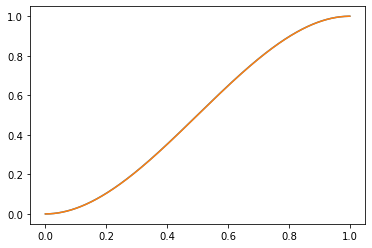

In [254]:
plt.plot(grid, sums)
plt.plot(grid, beta.cdf(grid, a, b))

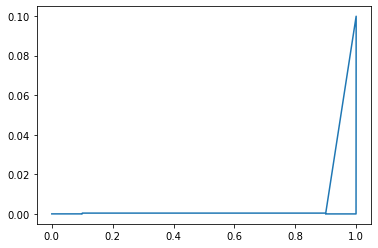

In [245]:
plt.plot(grid[1:], grid_width)
plt.show()

-9.990999099929176e-06

In [238]:
grid[1:]

array([1.09990999e-04, 1.19981998e-04, 1.29972997e-04, ...,
       9.00019982e-01, 9.00009991e-01, 9.00000000e-01])

In [222]:
grid[:-1]

array([1.00000000e-04, 1.15139540e-04, 1.32571137e-04, ...,
       9.34487144e-01, 9.24568799e-01, 9.13148863e-01])